In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import pandas as pd
import configs
import torch
from sklearn.decomposition import PCA
from scipy.spatial.distance import pdist, squareform

from src.utils import find_ckpt_file, convert_to_tensor
import h5py
import random
from src.evals.eval_trees import EvalTrees
from src.evals.eval_trees import EvalCntrees

In [2]:
from transformers import set_seed

In [3]:
set_seed(0)

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load Model

In [5]:
engram_dir = "/n/holylfs06/LABS/krajan_lab/Lab/cfang/icl-maze/"
wandb_project = "tree_maze"
corr = 0.25
env_name = f"cntree_layers7_bprob0.9_corr{corr}_state_dim10_envs300000_H800_explore"
eval_dset_path = f"/n/holylfs06/LABS/krajan_lab/Lab/cfang/icl-maze/cntree/cntree_layers7_bprob1.0_corr{corr}_state_dim10_envs1000_H1600_explore/datasets/eval.pkl"

# Load Dataset and Create Environment

In [6]:
n_eval_envs = 50

is_h5_file = eval_dset_path.endswith('.h5')
if is_h5_file:
    eval_trajs = h5py.File(eval_dset_path, 'r')
    traj_indices = list(eval_trajs.keys())
    n_eval_envs = min(n_eval_envs, len(traj_indices))
    random.seed(0)
    traj_indices = random.sample(traj_indices, n_eval_envs)
    random.seed()
    eval_trajs = [eval_trajs[i] for i in traj_indices]
else:  # Pickle file
    with open(eval_dset_path, 'rb') as f:
        eval_trajs = pickle.load(f)
    n_eval_envs = min(n_eval_envs, len(eval_trajs))
    random.seed(0)
    eval_trajs = random.sample(eval_trajs, n_eval_envs)
    random.seed()


In [7]:
i_eval = 3
traj = eval_trajs[i_eval]
env_config = {
    'max_layers': 7,
    'horizon': 1600,
    'branching_prob': 1.0,
    'node_encoding_corr': corr,
    'state_dim': 10,
    'initialization_seed': np.array(traj['initialization_seed']).item()
}
env = EvalCntrees().create_env(env_config, np.array(traj['goal']), i_eval)

In [8]:
traj.keys()

dict_keys(['query_state', 'optimal_action', 'context_states', 'context_actions', 'context_next_states', 'context_rewards', 'goal', 'initialization_seed'])

In [9]:
import torch.nn as nn
import torch.nn.functional as F

class CPCModel(nn.Module):
    def __init__(self, input_dim, encoding_dim=64):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, encoding_dim * 2),
            nn.LayerNorm(encoding_dim * 2),
            nn.ReLU(),
            nn.Linear(encoding_dim * 2, encoding_dim),
            nn.LayerNorm(encoding_dim)
        )
        
    def forward(self, x):
        # x shape: (batch_size, sequence_length, input_dim)
        encoded = self.encoder(x)  # (batch_size, seq_len, encoding_dim)
        return encoded

In [10]:
def prepare_sequence_data(traj, sequence_length):
    # Combine states and next states to create a sequence
    states = np.array(traj['context_states'])
    full_sequence = states

    # Create sequences of length sequence_length
    sequences = []
    start_indices = np.random.choice(
        len(full_sequence) - sequence_length + 1,
        size=len(full_sequence) - sequence_length + 1,
        replace=False)
    for i in start_indices:
        sequences.append(full_sequence[i:i+sequence_length])
    
    return torch.FloatTensor(np.array(sequences))

def train_cpc(
        model, traj,
        n_epochs=100, lr=1e-3,
        n_prediction_steps=10, pos_weight=1,
        print_losses=True):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    train_losses = []
    
    for epoch in range(n_epochs):

        optimizer.zero_grad()
        encoded = model(traj)

        total_loss = 0
        # Compute loss for different time offsets
        for k in range(1, n_prediction_steps + 1):
            # Positive samples: pairs that are k steps apart
            pos = (encoded[k:] * encoded[:-k]).sum(dim=-1)
            
            # Negative samples: all other pairs at k steps apart
            neg = torch.matmul(encoded[k:], encoded[:-k].T).squeeze()
            
            # Compute NCE loss for this time offset
            neg_weight = 1-pos_weight
            step_loss = (-pos*pos_weight + neg_weight * torch.logsumexp(neg, dim=-1)).mean()
            total_loss += step_loss / n_prediction_steps
        
        total_loss.backward()
        optimizer.step()
        
        loss_val = total_loss.item()
        if print_losses and (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch+1}, Loss: {loss_val:.4f}")
        train_losses.append(loss_val)

    return train_losses

In [11]:
# Create and train the model
input_dim = traj['context_states'].shape[-1]  # Should be 10 based on your env config
_traj = torch.FloatTensor(traj['context_states']).to(device)
_traj = _traj[:1000]

In [12]:
def get_kernel_alignment(K_A, K_B):
    """ Centered Kernel Alignment """
    n = K_A.shape[0]
    I = np.eye(n)
    H = I - np.ones((n, n)) / n
    K_A_centered = H @ K_A @ H
    K_B_centered = H @ K_B @ H
    
    # Compute alignment using Frobenius norm
    numerator = np.sum(K_A_centered * K_B_centered)
    denominator = np.sqrt(np.sum(K_A_centered * K_A_centered) * np.sum(K_B_centered * K_B_centered))
    
    return numerator / denominator if denominator != 0 else 0

In [13]:
layers = []
positions = []
state_features = []
state_features = list(env.node_map.keys())

for state_feature in state_features:
    layers.append(env.node_map[state_feature].layer)
    positions.append(env.node_map[state_feature].pos)

In [14]:
true_dist_matrix = []

for state_feature in state_features:
    _, dist_from_state = env._make_opt_action_dict(state_feature)
    sorted_dist_from_state = []
    for state_feature in state_features:
        sorted_dist_from_state.append(dist_from_state[state_feature])
    true_dist_matrix.append(sorted_dist_from_state)

true_dist_matrix = np.array(true_dist_matrix)


In [15]:
def run_model(model, state_features):
    hidden_states = []
    for state in state_features:
        # Create a sequence with just the single state repeated
        state_tensor = torch.FloatTensor(state).unsqueeze(0).unsqueeze(0)  # Add batch and sequence dims
        
        # Get model representations
        with torch.no_grad():
            encoded = model.encoder(state_tensor.to(device))
            hidden_states.append(encoded.squeeze())
    
    return hidden_states

In [41]:
recalc = True

if recalc:
    results = {
        'kernel_alignment': [],
        'gamma': [],
        'pred_steps': [],
        'pos_weight': [],
        'pos_weight_idx': []
    }
    gammas = np.arange(0.1, 1.0, 0.1)
    
    #pred_steps = 80
    #pos_weights = np.logspace(-1.7, -1.5, 10)
    
    pos_weights = np.logspace(-1.7, -1.1, 20)
    
    for pred_steps in [20, 40, 80, 100, 150]:
        for pos_weight_idx, pos_weight in enumerate(pos_weights):
            model = CPCModel(input_dim=input_dim, encoding_dim=256).to(device)
            train_losses = train_cpc(
                model, _traj, n_epochs=2000, lr=1e-3, n_prediction_steps=pred_steps, pos_weight=pos_weight)
            hidden_states = run_model(model, state_features)
            data = torch.stack(hidden_states)
            data = data.detach().cpu().numpy().squeeze()  # (states, sequence length, hidden dim)
            data -= data.mean(0)[None,:]
            for gamma in gammas:
                K_input = gamma ** true_dist_matrix # exponential kernel
                K_latents = data @ data.T
                kernel_alignment = get_kernel_alignment(K_input, K_latents)
                results['kernel_alignment'].append(kernel_alignment)
                results['gamma'].append(gamma)
                results['pred_steps'].append(pred_steps)
                results['pos_weight'].append(pos_weight)
                results['pos_weight_idx'].append(pos_weight_idx)

    df = pd.DataFrame(results)
    with open('pickles/09_cpc_within_env.pkl', 'wb') as f:
        pickle.dump(df, f)
else:
    with open('pickles/09_cpc_within_env.pkl', 'rb') as f:
        df = pickle.load(f)


Epoch 10, Loss: 239.9474
Epoch 20, Loss: 230.3677
Epoch 30, Loss: 220.9419
Epoch 40, Loss: 211.7065
Epoch 50, Loss: 202.7120
Epoch 60, Loss: 193.9791
Epoch 70, Loss: 185.5166
Epoch 80, Loss: 177.3104
Epoch 90, Loss: 169.3160
Epoch 100, Loss: 161.4614
Epoch 110, Loss: 153.6543
Epoch 120, Loss: 145.8735
Epoch 130, Loss: 138.2115
Epoch 140, Loss: 130.8135
Epoch 150, Loss: 123.7840
Epoch 160, Loss: 117.1657
Epoch 170, Loss: 110.9723
Epoch 180, Loss: 105.2020
Epoch 190, Loss: 99.8379
Epoch 200, Loss: 94.8561
Epoch 210, Loss: 90.2099
Epoch 220, Loss: 85.8754
Epoch 230, Loss: 81.8175
Epoch 240, Loss: 78.0089
Epoch 250, Loss: 74.4247
Epoch 260, Loss: 71.0443
Epoch 270, Loss: 67.8497
Epoch 280, Loss: 64.8250
Epoch 290, Loss: 61.9586
Epoch 300, Loss: 59.2373
Epoch 310, Loss: 56.6508
Epoch 320, Loss: 54.1906
Epoch 330, Loss: 51.8505
Epoch 340, Loss: 49.6191
Epoch 350, Loss: 47.4956
Epoch 360, Loss: 45.4692
Epoch 370, Loss: 43.5370
Epoch 380, Loss: 41.6949
Epoch 390, Loss: 39.9359
Epoch 400, Loss:

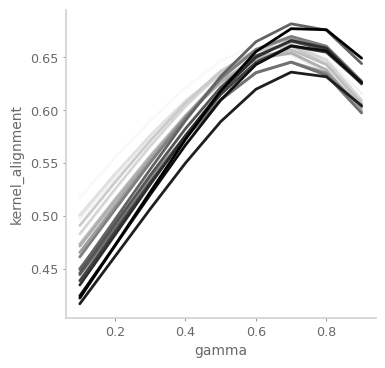

In [79]:
_df = df[df['pred_steps']==20]

fig, ax = plt.subplots(figsize=(4, 4))
sns.lineplot(
    data=_df, x='gamma', y='kernel_alignment',
    hue='pos_weight_idx', linewidth=2,
    palette='Greys', legend=False # Using grayscale palette
)
plt.show()

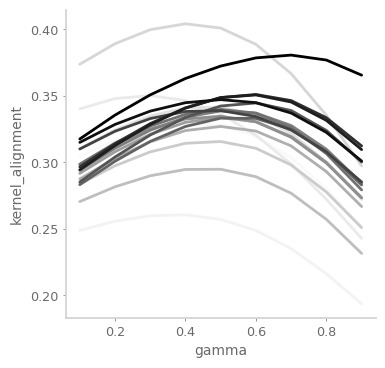

In [80]:
_df = df[df['pred_steps']==150]

fig, ax = plt.subplots(figsize=(4, 4))
sns.lineplot(
    data=_df, x='gamma', y='kernel_alignment',
    hue='pos_weight_idx', linewidth=2,
    palette='Greys', legend=False # Using grayscale palette
)
plt.show()

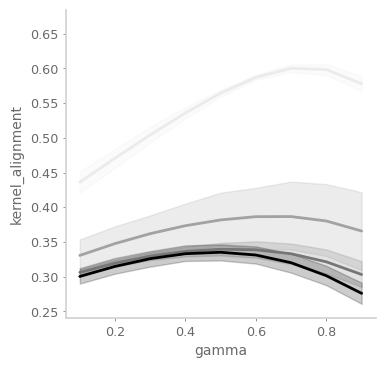

In [59]:
fig, ax = plt.subplots(figsize=(4, 4))
sns.lineplot(
    data=df, x='gamma', y='kernel_alignment',
    hue='pred_steps', linewidth=2,
    palette='Greys', legend=False # Using grayscale palette
)
plt.show()

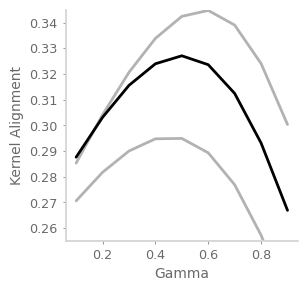

In [87]:
fig, ax = plt.subplots(figsize=(3, 3))

_df = df[df['pred_steps']==150]
_df = _df[_df['pos_weight_idx']==7]
sns.lineplot(
    data=_df, x='gamma', y='kernel_alignment',
    linewidth=2, color='black', ax=ax, alpha=0.3
)

_df = df[df['pred_steps']==150]
_df = _df[_df['pos_weight_idx']==14]
sns.lineplot(
    data=_df, x='gamma', y='kernel_alignment',
    linewidth=2, color='black', ax=ax, alpha=0.3
)

_df = df[df['pred_steps']==150]
_df = _df[_df['pos_weight_idx']==8]
sns.lineplot(
    data=_df, x='gamma', y='kernel_alignment',
    linewidth=2, color='black', ax=ax
)

plt.ylabel('Kernel Alignment')
plt.xlabel('Gamma')
plt.ylim(0.255, 0.345)
plt.show()

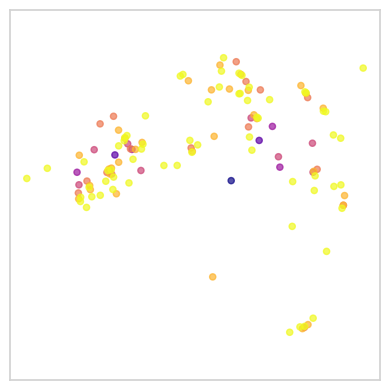

In [18]:
fig, ax = plt.subplots(figsize=(4, 4))
pca = PCA(n_components=2)
data_pca = pca.fit_transform(data)
data_pca = data_pca / np.abs(data_pca).max(axis=0)
# Plot the PCA results
ax.scatter(
   data_pca[:, 0], data_pca[:, 1],
   c=layers, cmap='plasma', s=20,
   alpha=0.7)
ax.set_aspect('equal', 'box')
ax.set_box_aspect(1)
ax.set_xticks([])
ax.set_yticks([])
# Add box outline on all sides
for spine in ax.spines.values():
    spine.set_visible(True)
plt.tight_layout()
plt.show()
